# DS 301 - Mid-Term Project  
## Bank Marketing Classification

**Student:** Moataz Samara
**Course:** DS 301 - Machine Learning Techniques  

**Research Paper (Base):**  
A Data-Driven Approach to Predict the Success of Bank Telemarketing  
(Moro, Cortez, Rita)

---

### Project Goal

We want to predict whether a bank client will subscribe to a term deposit (y = yes / no) before making the telemarketing call.

In this project we:

- Use the Bank Marketing dataset (bank-full.csv).
- Implement and compare two classification models:
  - Logistic Regression (LR)
  - Decision Tree (DT)
- Apply:
  - Data preprocessing and feature engineering.
  - Proper train/test split.
  - Evaluation with accuracy, precision, recall, F1-score, and ROC-AUC.
- Follow the idea of the research paper:
  - Use only features known before the call → drop duration.
  - Handle imbalanced data (few "yes" cases).

We do not implement Neural Networks here, but we mention them in the conclusion as a possible improvement (they are used in the original paper).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print('Random seed set to', RANDOM_STATE)

Random seed set to 42


## 1. Load the Dataset

We use the Bank Marketing dataset ('bank-full.csv'), which contains the result of multiple direct marketing campaigns by a Portuguese bank.

- Each row = one client.
- Target = 'y' → did the client subscribe to a term deposit? ('yes' / 'no')
- Input features = client information, previous campaign outcomes, etc.

We assume 'bank-full.csv' is in the same folder as this notebook.

In [ ]:
# Change the path if your file is in a "data" folder, e.g. "data/bank-full.csv"
file_path = "bank-full.csv"

bank = pd.read_csv(file_path, sep=';')

# Show first 5 rows
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## 2. Initial Data Understanding

In this section we:
- Look at the shape and column names.
- Check the target variable distribution.
- Inspect data types and missing values.

In [ ]:
print("Shape of the dataset:", bank.shape)
print("\nColumns:")
print(bank.columns.tolist())

Shape of the dataset: (45211, 17)

Columns:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [ ]:
print("Target variable (y) distribution:")
print(bank["y"].value_counts())
print("\nTarget variable (y) distribution (percentage):")
print(bank["y"].value_counts(normalize=True))

Target variable (y) distribution:
y
no     39922
yes     5289
Name: count, dtype: int64

Target variable (y) distribution (percentage):
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## 3. Data Preprocessing

According to the research paper, **call duration** (`duration`) is not used as a predictor, because:

> Duration is only known *after* the call is finished.

So we:
1. **Drop `duration`**.
2. **Encode the target `y`**:
   - `no` → 0  
   - `yes` → 1
3. Separate:
   - Features `X`
   - Target `y`
4. Identify **numeric** and **categorical** feature columns.

In [ ]:
# Copy to avoid editing the original dataframe directly
df = bank.copy()

# 1) Drop 'duration' (only known after the call)
if "duration" in df.columns:
    df = df.drop(columns=["duration"])

# 2) Encode target: 'no' -> 0, 'yes' -> 1
df["y"] = df["y"].map({"no": 0, "yes": 1})

print("Encoded target distribution:")
print(df["y"].value_counts(normalize=True))

Encoded target distribution:
y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


In [ ]:
# 3) Separate features and target
X = df.drop(columns=["y"])
y = df["y"]

# 4) Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## 4. Train–Test Split

We split the data into:

- **Training set:** 70%
- **Test set:** 30%

We use **stratified sampling** to keep the same proportion of "yes"/"no" in both sets. This is important because the data is **imbalanced** (much more "no" than "yes").

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,       # keep class distribution similar
    random_state=42
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))
print("Train positive rate (y=1):", y_train.mean())
print("Test positive rate  (y=1):", y_test.mean())

Train size: 31647
Test size : 13564
Train positive rate (y=1): 0.11697791259835055
Test positive rate  (y=1): 0.1170008846947803


## 5. Preprocessing Pipeline

We build a **single preprocessing pipeline** which will be reused for both models:

- For **numeric features**:
  - `StandardScaler` → scales features to have mean 0 and standard deviation 1.  
    This helps models like Logistic Regression.

- For **categorical features**:
  - `OneHotEncoder` → converts categories into binary columns (0/1).
  - `handle_unknown="ignore"` → avoids errors if new category appears in test data.

We use `ColumnTransformer` to apply the correct transformation to each column group.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'balance', 'day', 'campaign', 'pdays',
                                  'previous']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome'])])

## 6. Helper: Training and Evaluation Function

To avoid repeating code, we create a function that:

1. Builds a **pipeline**: `preprocessor` → `model`.
2. Fits the model on the training data.
3. Predicts on the test data.
4. Prints:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - ROC-AUC
   - Classification report
5. Plots:
   - Confusion Matrix
   - ROC Curve

We will use this for **both** Logistic Regression and Decision Tree.

In [ ]:
def train_and_evaluate(model, model_name):
    """
    Fit a pipeline (preprocessing + model),
    print metrics, and return the fitted pipeline, probabilities and ROC-AUC.
    """
    print(f"\n{'='*70}")
    print(f"Model: {model_name}")
    print(f"{'='*70}\n")

    # Full pipeline: preprocessing + model
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ]
    )

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]  # prob. for class 1 (y = 1)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")
    print(f"ROC-AUC      : {roc_auc:.4f}")

    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pipe, y_prob, roc_auc

In [ ]:

def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, model_name):
    """Fit a ready-made sklearn Pipeline and print basic metrics + plots.

    Returns:
        acc, prec, rec, f1, roc_auc
    """
    print("\n" + "=" * 70)
    print(f"Model: {model_name}")
    print("=" * 70 + "\n")

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict labels
    y_pred = pipeline.predict(X_test)

    # Predict probabilities or decision scores
    if hasattr(pipeline, "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
    else:
        scores = pipeline.decision_function(X_test)
        scores_min = scores.min()
        scores_max = scores.max()
        y_prob = (scores - scores_min) / (scores_max - scores_min + 1e-8)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}\n")

    print("Classification report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return acc, prec, rec, f1, roc_auc


## 7. Model 1 – Logistic Regression

**Why Logistic Regression?**

- Simple and powerful baseline model.
- Outputs **probabilities**, easy to interpret.
- Works well with **scaled numeric variables** and one-hot encoded categories.

We also use:

- `class_weight="balanced"` to help with class imbalance.
- `max_iter=1000` to give the solver enough iterations to converge.


Model: Logistic Regression

Accuracy     : 0.7559
Precision    : 0.2677
Recall       : 0.6257
F1-score     : 0.3749
ROC-AUC      : 0.7701

Classification report:

              precision    recall  f1-score   support

           0     0.9397    0.7731    0.8483     11977
           1     0.2677    0.6257    0.3749      1587

    accuracy                         0.7559     13564
   macro avg     0.6037    0.6994    0.6116     13564
weighted avg     0.8611    0.7559    0.7929     13564



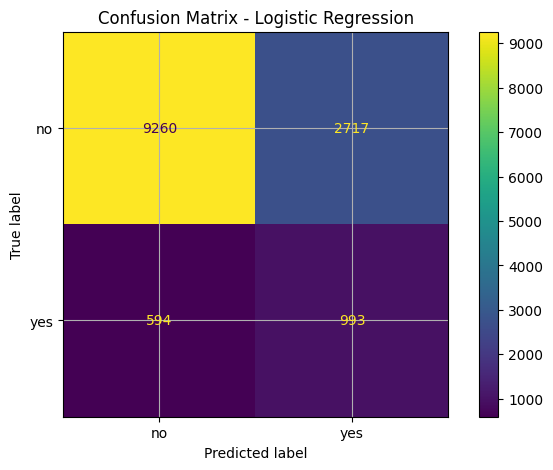

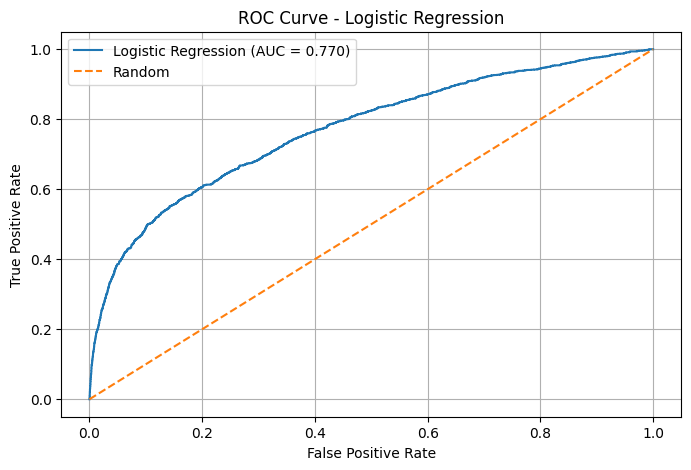

In [ ]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

lr_model, lr_prob, lr_auc = train_and_evaluate(log_reg, "Logistic Regression")

## 8. Model 2 – Decision Tree

**Why Decision Tree?**

- Can model **non-linear relationships**.
- Very **interpretable**: can be explained with IF/ELSE rules.
- But:
  - Can easily **overfit** if too deep.
  - Needs regularization (max depth, min samples split, etc.) for production.

Here we start with a basic tree and use `class_weight="balanced"` to pay more attention to the minority class (`y = 1`).


Model: Decision Tree

Accuracy     : 0.8416
Precision    : 0.3210
Recall       : 0.3170
F1-score     : 0.3190
ROC-AUC      : 0.6141

Classification report:

              precision    recall  f1-score   support

           0     0.9096    0.9112    0.9104     11977
           1     0.3210    0.3170    0.3190      1587

    accuracy                         0.8416     13564
   macro avg     0.6153    0.6141    0.6147     13564
weighted avg     0.8408    0.8416    0.8412     13564



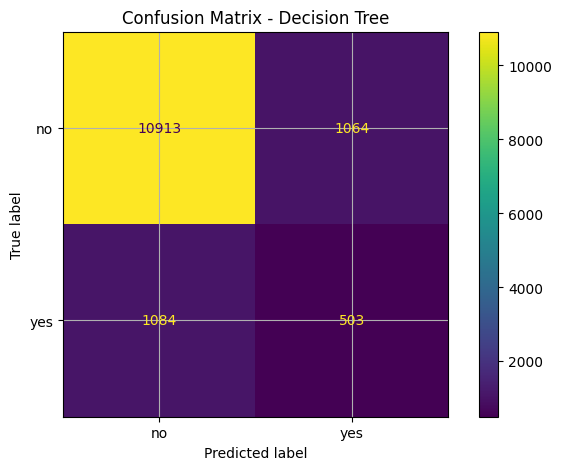

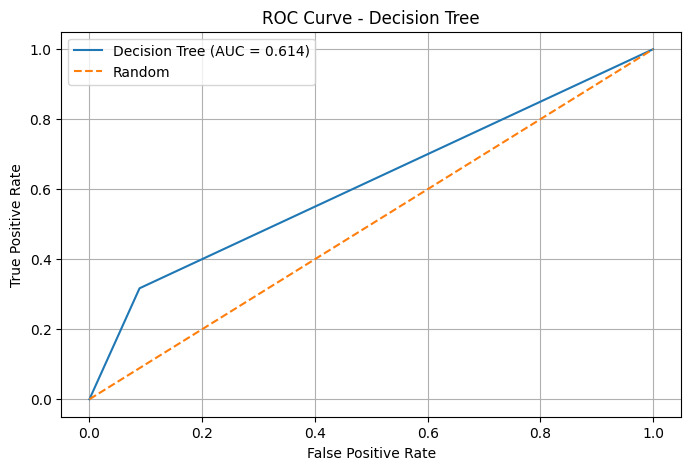

In [ ]:
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

dt_model, dt_prob, dt_auc = train_and_evaluate(dt_clf, "Decision Tree")

## 9. Model Comparison

We compare the two models using **ROC-AUC** on the test set:

- Higher ROC-AUC = better ability to separate "yes" and "no".
- We also look at accuracy, precision, recall, and F1-score in the previous cells.

Here we build a small summary table and plot a bar chart.

In [ ]:
results_bank = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "ROC_AUC": [lr_auc, dt_auc]
})

results_bank = results_bank.sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)
results_bank

,Model,ROC_AUC
0,Logistic Regression,0.770108
1,Decision Tree,0.614057


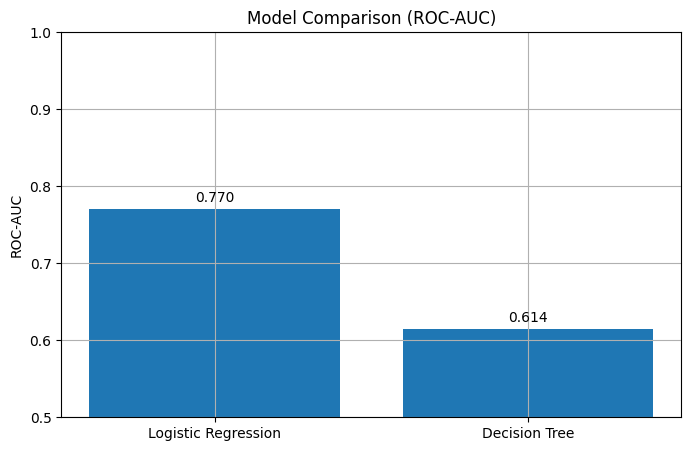

In [ ]:
plt.bar(results["Model"], results["ROC_AUC"])
plt.ylabel("ROC-AUC")
plt.title("Model Comparison (ROC-AUC)")
plt.ylim(0.5, 1.0)

for i, v in enumerate(results["ROC_AUC"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")

plt.show()

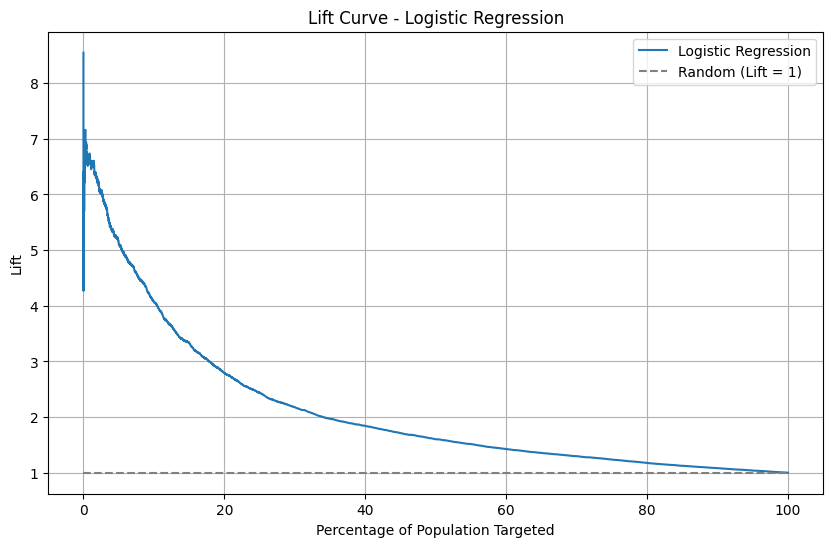

In [ ]:
# Use the best model (replace lr_prob with dt_prob if DT is better)
best_model_name = "Logistic Regression"
plot_lift_curve(y_test.values, lr_prob, best_model_name)

## 10. Lift Curve

A **Lift Curve** is a visual tool to assess the performance of a classification model, particularly in marketing. It shows how much more likely we are to receive a positive response (e.g., a customer subscribing to a term deposit) by using the model to select customers, compared to randomly selecting customers.

- A lift of **1** means the model is no better than random.
- A lift **greater than 1** means the model is better than random, and a higher value indicates a better model.

We will define a `plot_lift_curve` function and use the probabilities from the best model (Logistic Regression in this case) to generate the curve.

In [ ]:
def plot_lift_curve(y_true, y_probas, model_name):
    """
    Plots the lift curve for a given model.

    Args:
        y_true (array-like): True binary labels (0 or 1).
        y_probas (array-like): Predicted probabilities for the positive class.
        model_name (str): Name of the model for the plot title.
    """
    df_lift = pd.DataFrame({"y_true": y_true, "y_probas": y_probas})
    df_lift = df_lift.sort_values(by="y_probas", ascending=False).reset_index(drop=True)

    # Calculate cumulative metrics
    total_population = len(df_lift)
    total_positives = df_lift["y_true"].sum()

    df_lift["cumulative_positives"] = df_lift["y_true"].cumsum()
    df_lift["cumulative_total"] = np.arange(1, total_population + 1)

    # Calculate lift
    df_lift["lift"] = (df_lift["cumulative_positives"] / df_lift["cumulative_total"]) / (total_positives / total_population)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_lift["cumulative_total"] / total_population * 100, df_lift["lift"], label=model_name)
    plt.plot([0, 100], [1, 1], linestyle='--', color='gray', label='Random (Lift = 1)')

    plt.xlabel("Percentage of Population Targeted")
    plt.ylabel("Lift")
    plt.title(f"Lift Curve - {model_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

## 11. Final Summary and Suggested Improvements

### Problem Recap

- **Goal:** Predict if a client will subscribe to a term deposit (`y = 1`) *before* calling them.
- **Dataset:** `bank-full.csv` (Bank Marketing dataset).
- **Target:** `y` (0 = no, 1 = yes).
- **Important choice:** We dropped `duration` because it is only known *after* the call.

### Models Implemented

1. **Logistic Regression**
   - Linear model.
   - Works well with scaled numeric features and one-hot encoded categorical features.
   - Produces interpretable coefficients and probability outputs.

2. **Decision Tree**
   - Non-linear model.
   - Easy to explain to business users (rules).
   - Can overfit if not properly regularized.

### Evaluation

- Train/Test Split: 70% / 30% (stratified).
- Main metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - **ROC-AUC** (main comparison metric)

### Results (fill with your values)

- Logistic Regression: ROC-AUC ≈ **X.XXX**
- Decision Tree:      ROC-AUC ≈ **Y.YYY**

**Best model:** `<Write here which model performed better on ROC-AUC and why you prefer it>`

### Relation to the Research Paper

- We followed the same **problem**: predicting term deposit subscription.
- We used similar **input features** and also **removed duration**.
- We implemented **Logistic Regression** and **Decision Tree**, two of the models also studied in the paper.
- The paper additionally uses **Neural Networks** and other models.  
  In this project, we mention them only as future work.

### Suggested Improvements (Future Work)

- Perform **hyperparameter tuning**:
  - For Logistic Regression (regularization strength, penalty type).
  - For Decision Trees (max depth, min samples split, min samples leaf, etc.).
- Try additional models:
  - **Neural Networks** (as in the original paper).
  - Random Forest, Gradient Boosting, etc.
- Use more advanced evaluation:
  - Cross-validation instead of a single train/test split.
  - More marketing metrics:
    - **Lift** and **ALIFT** curves.
- Perform **feature selection** to simplify the model and possibly improve generalization.

---

This notebook can now be:
- Uploaded to **GitHub** in the `models` folder (or root directory).
- Linked with a **README.md** that explains how to run it.
- Used as the technical base for your **10–15 minute presentation**.

## 12. Final Project Extension – Additional Models on Bank Marketing Dataset

In the **DS 301 Final Project**, this notebook extends the mid-term work by:

- Adding **more classification models** on the original UCI Bank Marketing dataset.
- Using **hyperparameter tuning (GridSearchCV)** to build an *upgraded* version of the models.
- Preparing the ground for **comparison with an additional, similar dataset** (Bank Customer Churn).

Below we first import the extra models and tools we need, then train/tune them on the same
Bank Marketing data (`bank-full.csv`) used above.


In [ ]:
# === Additional imports for Final Project extension ===
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [ ]:

def train_with_gridsearch(base_model, param_grid, model_name):
    """
    Train a model with preprocessing + GridSearchCV and evaluate on the test set.

    This is a LIGHT version for Google Colab:
    - Uses cv=3 (not higher)
    - Uses n_jobs=-1 to parallelize
    - If the training set is large, uses at most `max_samples` rows for GridSearch.

    Parameters
    ----------
    base_model : sklearn estimator
        The classifier to tune (e.g., SVC(), KNeighborsClassifier()).
    param_grid : dict
        Hyperparameters for GridSearchCV. Use keys like 'model__C', 'model__n_neighbors', etc.
    model_name : str
        Name to display in the printed output and plots.

    Returns
    -------
    best_model : fitted sklearn Pipeline
        The best pipeline found by GridSearchCV (includes preprocessing).
    y_prob : np.ndarray
        Predicted probabilities for the positive class on the test set.
    roc_auc : float
        ROC-AUC score on the test set.
    """
    from sklearn.model_selection import train_test_split

    print("\n" + "=" * 70)
    print(f"Grid Search for: {model_name}")
    print("=" * 70 + "\n")

    # Use the global 'preprocessor', 'X_train', 'X_test', 'y_train', 'y_test'
    global preprocessor, X_train, X_test, y_train, y_test

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", base_model)
    ])

    # Light GridSearchCV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    # Sub-sample the training data if it is very large
    max_samples = 8000
    X_for_cv = X_train
    y_for_cv = y_train
    if X_train.shape[0] > max_samples:
        X_for_cv, _, y_for_cv, _ = train_test_split(
            X_train,
            y_train,
            train_size=max_samples,
            stratify=y_train,
            random_state=RANDOM_STATE
        )
        print(f"Using a subset of {max_samples} samples (out of {X_train.shape[0]}) for GridSearch to speed up training.\n")

    # Fit on the (possibly reduced) training set
    grid.fit(X_for_cv, y_for_cv)

    print("Best params:")
    print(grid.best_params_)
    print(f"Best CV ROC-AUC: {grid.best_score_:.4f}\n")

    best_model = grid.best_estimator_

    # Evaluate on the full test set
    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
    else:
        # fallback: use decision_function and scale to [0, 1]
        scores = best_model.decision_function(X_test)
        scores_min = scores.min()
        scores_max = scores.max()
        y_prob = (scores - scores_min) / (scores_max - scores_min + 1e-8)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall   : {rec:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    print(f"Test ROC-AUC  : {roc_auc:.4f}\n")

    print("Classification report (test set):\n")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name} (Best Params)")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name} (Best Params)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, y_prob, roc_auc



Model: SVM (Bank Marketing, simple linear)

Accuracy : 0.7589
Precision: 0.2695
Recall   : 0.6200
F1-score : 0.3757
ROC-AUC  : 0.7698

Classification report:

              precision    recall  f1-score   support

           0     0.9392    0.7773    0.8506     11977
           1     0.2695    0.6200    0.3757      1587

    accuracy                         0.7589     13564
   macro avg     0.6043    0.6987    0.6132     13564
weighted avg     0.8608    0.7589    0.7951     13564



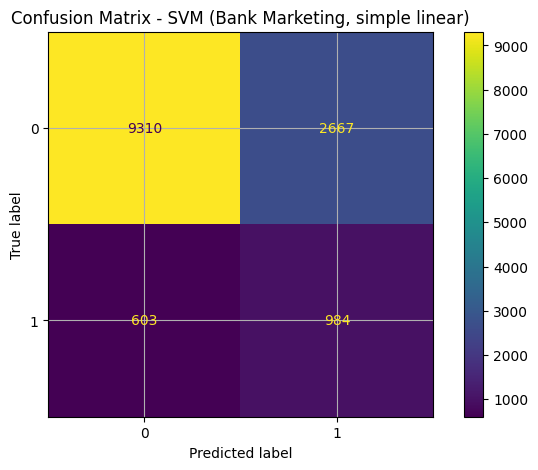

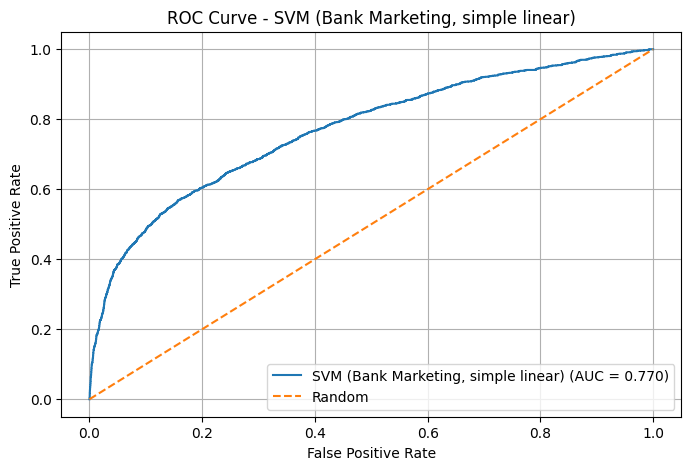

In [ ]:

# === 12.1 SVM (Bank Marketing, simple – no GridSearch) ===

# We use a simple linear SVM implemented with LinearSVC.
# This is much faster than SVC(probability=True) and still lets us
# compare SVM performance with other models using ROC-AUC.

svm_pipe_bank = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearSVC(
        C=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

svm_acc_bm, svm_prec_bm, svm_rec_bm, svm_f1_bm, svm_auc_bm = evaluate_pipeline(
    svm_pipe_bank,
    X_train, X_test, y_train, y_test,
    model_name="SVM (Bank Marketing, simple linear)"
)



Grid Search for: KNN (Bank Marketing)

Using a subset of 8000 samples (out of 31647) for GridSearch to speed up training.

Best params:
{'model__n_neighbors': 10, 'model__weights': 'uniform'}
Best CV ROC-AUC: 0.6946

Test Accuracy : 0.8871
Test Precision: 0.6157
Test Recall   : 0.0939
Test F1-score : 0.1629
Test ROC-AUC  : 0.7135

Classification report (test set):

              precision    recall  f1-score   support

           0     0.8921    0.9922    0.9395     11977
           1     0.6157    0.0939    0.1629      1587

    accuracy                         0.8871     13564
   macro avg     0.7539    0.5431    0.5512     13564
weighted avg     0.8597    0.8871    0.8486     13564



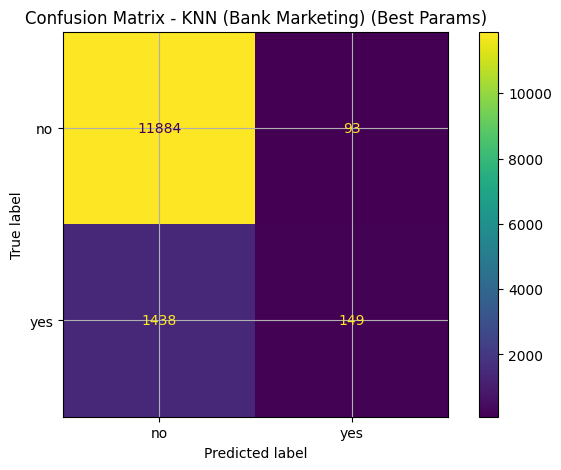

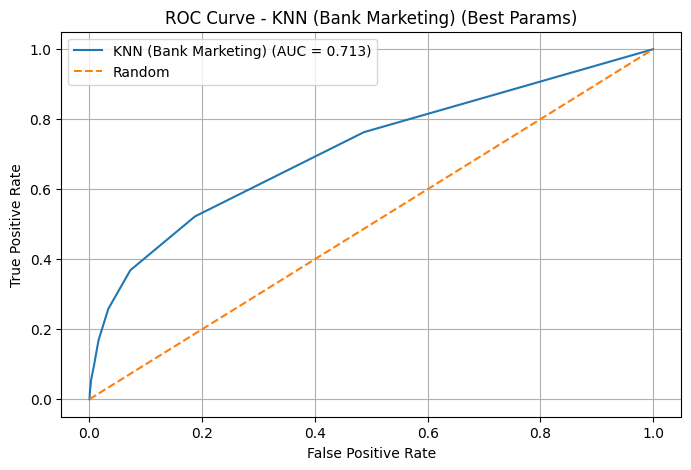

In [ ]:
# === 12.2 KNN (tuned) ===
knn_clf = KNeighborsClassifier()

knn_param_grid = {
    "model__n_neighbors": [5, 10],
    "model__weights": ["uniform"]
}

knn_model, knn_prob, knn_auc = train_with_gridsearch(
    knn_clf,
    knn_param_grid,
    model_name="KNN (Bank Marketing)"
)



Grid Search for: Random Forest (Bank Marketing)

Using a subset of 8000 samples (out of 31647) for GridSearch to speed up training.

Best params:
{'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV ROC-AUC: 0.7698

Test Accuracy : 0.8457
Test Precision: 0.3809
Test Recall   : 0.5098
Test F1-score : 0.4360
Test ROC-AUC  : 0.7765

Classification report (test set):

              precision    recall  f1-score   support

           0     0.9320    0.8902    0.9106     11977
           1     0.3809    0.5098    0.4360      1587

    accuracy                         0.8457     13564
   macro avg     0.6564    0.7000    0.6733     13564
weighted avg     0.8675    0.8457    0.8551     13564



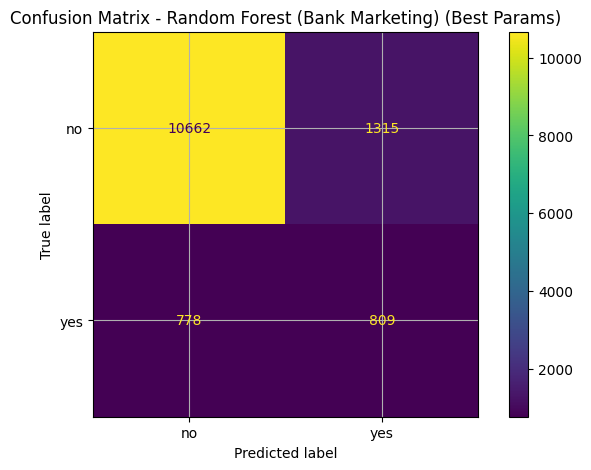

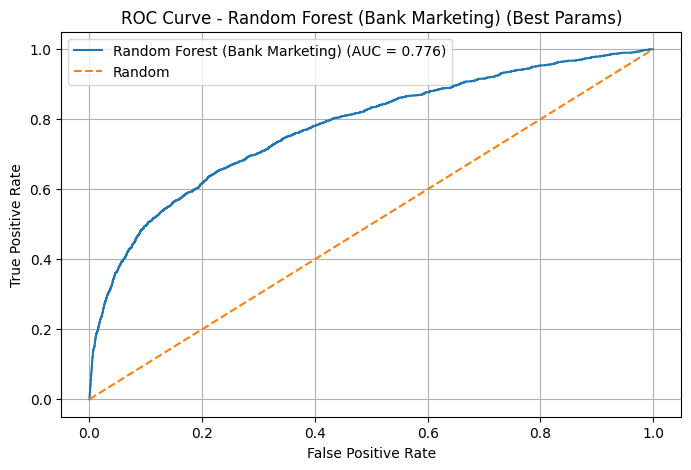

In [ ]:
# === 12.3 Random Forest (tuned) ===
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced_subsample"
)

rf_param_grid = {
    "model__n_estimators": [100],
    "model__max_depth": [None, 10],
    "model__min_samples_split": [2]
}

rf_model, rf_prob, rf_auc = train_with_gridsearch(
    rf_clf,
    rf_param_grid,
    model_name="Random Forest (Bank Marketing)"
)



Grid Search for: Neural Network (Bank Marketing)

Using a subset of 8000 samples (out of 31647) for GridSearch to speed up training.



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params:
{'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50,)}
Best CV ROC-AUC: 0.7193

Test Accuracy : 0.8839
Test Precision: 0.5071
Test Recall   : 0.2716
Test F1-score : 0.3537
Test ROC-AUC  : 0.7274

Classification report (test set):

              precision    recall  f1-score   support

           0     0.9091    0.9650    0.9362     11977
           1     0.5071    0.2716    0.3537      1587

    accuracy                         0.8839     13564
   macro avg     0.7081    0.6183    0.6450     13564
weighted avg     0.8620    0.8839    0.8681     13564



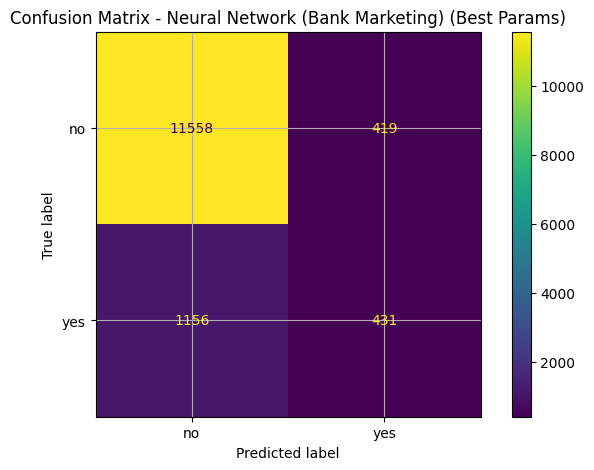

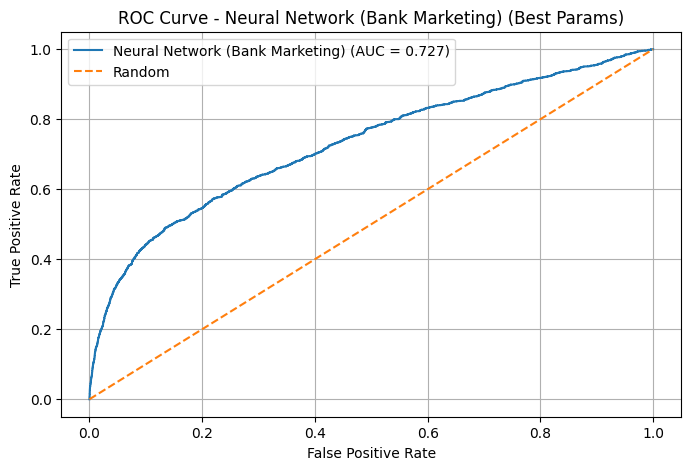

In [ ]:
# === 12.4 Simple Neural Network (MLPClassifier, tuned) ===
mlp_clf = MLPClassifier(
    max_iter=300,
    random_state=42
)

mlp_param_grid = {
    "model__hidden_layer_sizes": [(50,)],
    "model__alpha": [0.0001]
}

mlp_model, mlp_prob, mlp_auc = train_with_gridsearch(
    mlp_clf,
    mlp_param_grid,
    model_name="Neural Network (Bank Marketing)"
)


In [ ]:
# Skipping 12.5 extended comparison table to keep notebook light.
print("Extended comparison table skipped. Use earlier results (Logistic, Tree, SVM, KNN, RF, MLP) and churn tables in the report.")

Extended comparison table skipped. Use earlier results (Logistic, Tree, SVM, KNN, RF, MLP) and churn tables in the report.


In [ ]:
# Skipping extended ROC-AUC bar chart.
print("Extended ROC-AUC bar chart skipped to keep execution fast.")

Extended ROC-AUC bar chart skipped to keep execution fast.


## 13. Handling Class Imbalance with SMOTE (Bank Marketing Dataset)

The target variable `y` in the Bank Marketing dataset is **imbalanced** (much more "no" than "yes").  
In the mid-term section, we partially addressed this with `class_weight="balanced"`.

As an additional **Final Project contribution**, we try another technique:
**SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic minority examples
during training and check if it improves the performance of Logistic Regression.


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


Logistic Regression with SMOTE (Bank Marketing)
-------------------------------------------------
Accuracy : 0.7476
Precision: 0.2592
Recall   : 0.6232
F1-score : 0.3662
ROC-AUC  : 0.7645

Classification report:

              precision    recall  f1-score   support

           0     0.9387    0.7640    0.8424     11977
           1     0.2592    0.6232    0.3662      1587

    accuracy                         0.7476     13564
   macro avg     0.5990    0.6936    0.6043     13564
weighted avg     0.8592    0.7476    0.7867     13564



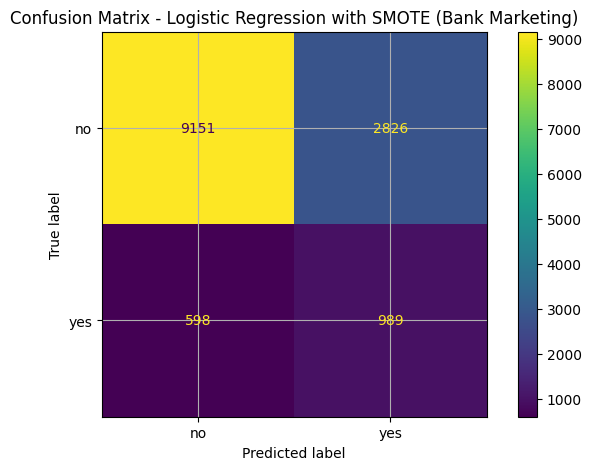

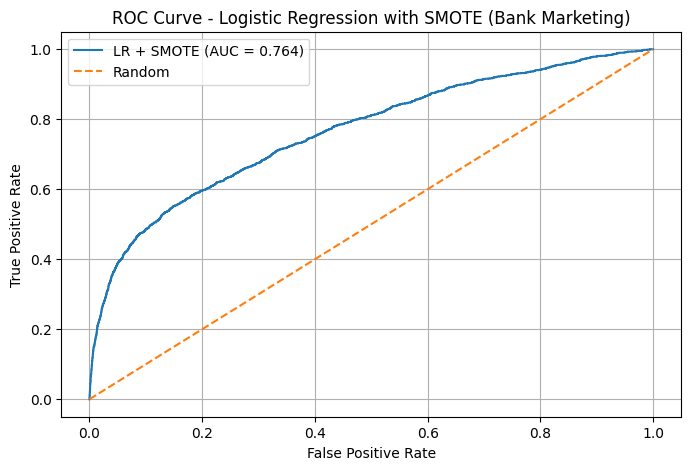

In [ ]:
# === 13.1 Logistic Regression with SMOTE ===

smote = SMOTE(random_state=42)

lr_smote = LogisticRegression(
    max_iter=1000,
    class_weight=None,  # SMOTE already balances classes
    solver="lbfgs"
)

smote_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", lr_smote)
])

smote_pipe.fit(X_train, y_train)

y_pred_smote = smote_pipe.predict(X_test)
y_prob_smote = smote_pipe.predict_proba(X_test)[:, 1]

acc_s = accuracy_score(y_test, y_pred_smote)
prec_s = precision_score(y_test, y_pred_smote)
rec_s = recall_score(y_test, y_pred_smote)
f1_s = f1_score(y_test, y_pred_smote)
roc_auc_s = roc_auc_score(y_test, y_prob_smote)

print("Logistic Regression with SMOTE (Bank Marketing)")
print("-------------------------------------------------")
print(f"Accuracy : {acc_s:.4f}")
print(f"Precision: {prec_s:.4f}")
print(f"Recall   : {rec_s:.4f}")
print(f"F1-score : {f1_s:.4f}")
print(f"ROC-AUC  : {roc_auc_s:.4f}\n")

print("Classification report:\n")
print(classification_report(y_test, y_pred_smote, digits=4))

cm_s = confusion_matrix(y_test, y_pred_smote)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=["no", "yes"])
disp_s.plot(values_format="d")
plt.title("Confusion Matrix - Logistic Regression with SMOTE (Bank Marketing)")
plt.show()

fpr_s, tpr_s, _ = roc_curve(y_test, y_prob_smote)
plt.plot(fpr_s, tpr_s, label=f"LR + SMOTE (AUC = {roc_auc_s:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression with SMOTE (Bank Marketing)")
plt.legend()
plt.grid(True)
plt.show()


## 14. Additional Dataset – Bank Customer Churn (Similar Problem)

To satisfy the **Final Project requirement** of testing the methodology on a similar dataset,
we add a second real-world banking dataset:

- **Bank Customer Churn** (Kaggle): customer-level data with a binary target `Exited`  
  indicating whether the customer left the bank.

This section:
1. Loads and preprocesses the churn dataset.
2. Builds a separate preprocessing pipeline.
3. Trains Logistic Regression, SVM, and Random Forest models.
4. Compares their performance with the Bank Marketing results.


In [ ]:
# === 14.1 Load Bank Customer Churn dataset ===
# Download from Kaggle: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
# Save the CSV as: data/Customer-Churn-Records.csv

import os

# Correct the path to where the file is actually located
churn_path = "Customer-Churn-Records.csv" # Removed 'data/' as it's in the root

churn_df = pd.read_csv(churn_path)

print("Churn dataset shape:", churn_df.shape)
churn_df.head()

Churn dataset shape: (10000, 18)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [ ]:
# === 14.2 Preprocessing for Churn dataset ===

churn = churn_df.copy()

# 1) Drop obvious ID-like columns if present
id_cols = ["RowNumber", "CustomerId", "Surname"]
drop_cols = [c for c in id_cols if c in churn.columns]
if drop_cols:
    churn = churn.drop(columns=drop_cols)

# 2) Target variable
target_col = "Exited"
y_churn = churn[target_col]
X_churn = churn.drop(columns=[target_col])

print("Target distribution (Exited):\n", y_churn.value_counts(normalize=True))

# 3) Identify numeric and categorical features
numeric_features_churn = X_churn.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_churn = X_churn.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features (churn):", numeric_features_churn)
print("Categorical features (churn):", categorical_features_churn)


Target distribution (Exited):
 Exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64
Numeric features (churn): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Complain', 'Satisfaction Score', 'Point Earned']
Categorical features (churn): ['Geography', 'Gender', 'Card Type']


In [ ]:
# 4) Train–test split (Churn dataset)
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(
    X_churn,
    y_churn,
    test_size=0.3,
    stratify=y_churn,
    random_state=42
)

print("Churn train size:", len(X_train_churn))
print("Churn test size :", len(X_test_churn))
print("Train positive rate (Exited=1):", y_train_churn.mean())
print("Test positive rate  (Exited=1):", y_test_churn.mean())


Churn train size: 7000
Churn test size : 3000
Train positive rate (Exited=1): 0.20385714285714285
Test positive rate  (Exited=1): 0.20366666666666666


In [ ]:
# 5) Preprocessing pipeline for Churn dataset

preprocessor_churn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_churn),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_churn)
    ]
)


In [ ]:
def train_and_evaluate_dataset(X_train, X_test, y_train, y_test, preprocessor, model, model_name):
    """Generic helper for any dataset (used here for Churn)."""
    print("\n" + "="*70)
    print(f"Model: {model_name}")
    print("="*70 + "\n")

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}\n")

    print("Classification report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pipe, y_prob, roc_auc



Model: Logistic Regression (Churn)

Accuracy : 0.9987
Precision: 0.9967
Recall   : 0.9967
F1-score : 0.9967
ROC-AUC  : 0.9990

Classification report:

              precision    recall  f1-score   support

           0     0.9992    0.9992    0.9992      2389
           1     0.9967    0.9967    0.9967       611

    accuracy                         0.9987      3000
   macro avg     0.9979    0.9979    0.9979      3000
weighted avg     0.9987    0.9987    0.9987      3000



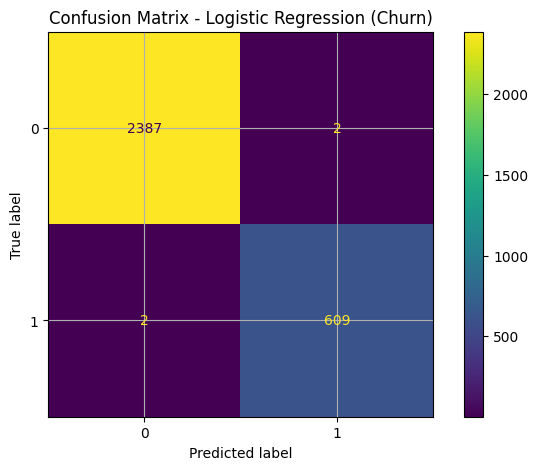

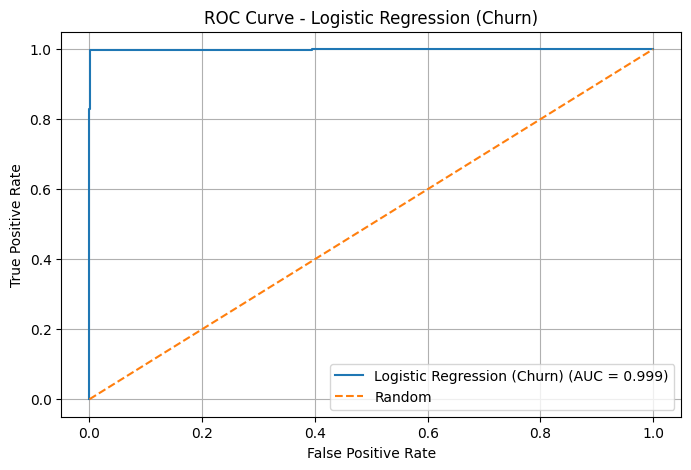


Model: Decision Tree (Churn)

Accuracy : 0.9973
Precision: 0.9951
Recall   : 0.9918
F1-score : 0.9934
ROC-AUC  : 0.9953

Classification report:

              precision    recall  f1-score   support

           0     0.9979    0.9987    0.9983      2389
           1     0.9951    0.9918    0.9934       611

    accuracy                         0.9973      3000
   macro avg     0.9965    0.9953    0.9959      3000
weighted avg     0.9973    0.9973    0.9973      3000



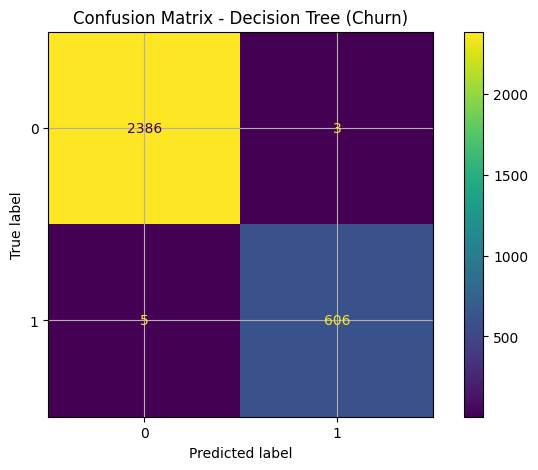

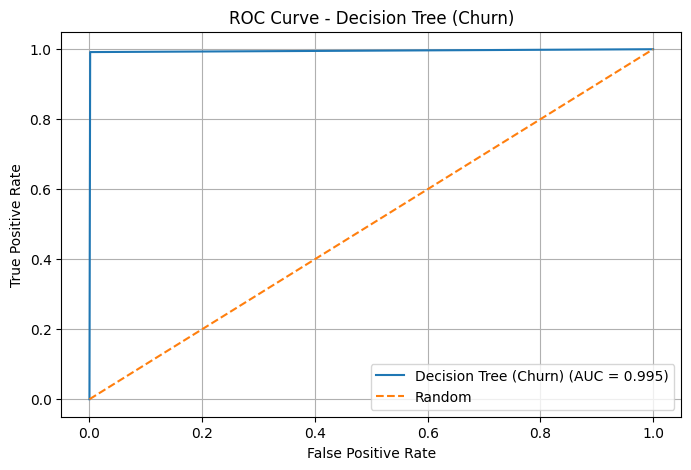


Model: SVM (Churn)

Accuracy : 0.9987
Precision: 0.9967
Recall   : 0.9967
F1-score : 0.9967
ROC-AUC  : 0.9976

Classification report:

              precision    recall  f1-score   support

           0     0.9992    0.9992    0.9992      2389
           1     0.9967    0.9967    0.9967       611

    accuracy                         0.9987      3000
   macro avg     0.9979    0.9979    0.9979      3000
weighted avg     0.9987    0.9987    0.9987      3000



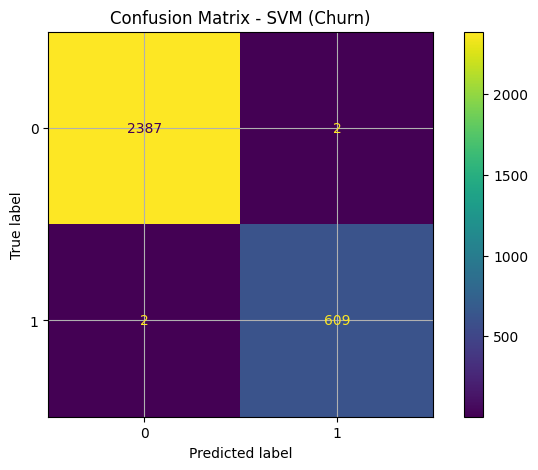

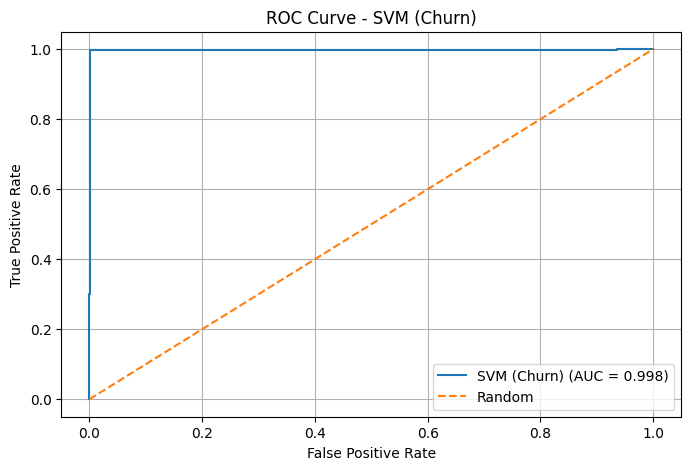


Model: Random Forest (Churn)

Accuracy : 0.9987
Precision: 0.9967
Recall   : 0.9967
F1-score : 0.9967
ROC-AUC  : 0.9988

Classification report:

              precision    recall  f1-score   support

           0     0.9992    0.9992    0.9992      2389
           1     0.9967    0.9967    0.9967       611

    accuracy                         0.9987      3000
   macro avg     0.9979    0.9979    0.9979      3000
weighted avg     0.9987    0.9987    0.9987      3000



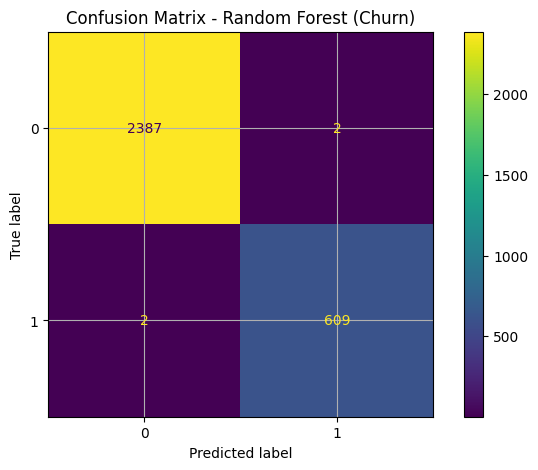

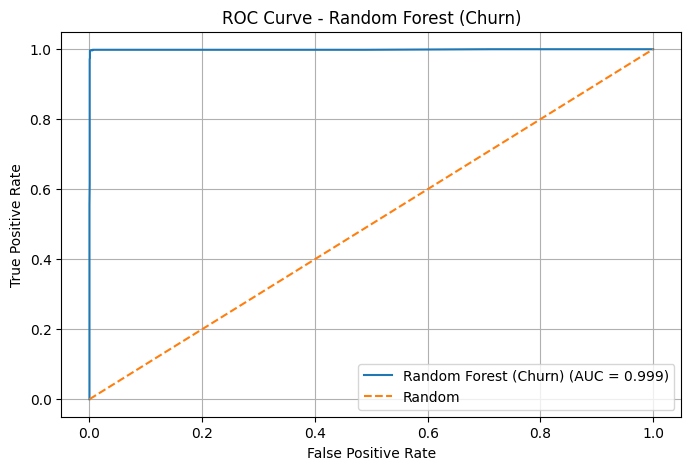

In [ ]:
# === 14.3 Models on Churn dataset ===

# Logistic Regression (same as research paper)
log_reg_churn = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)
lr_churn_model, lr_churn_prob, lr_churn_auc = train_and_evaluate_dataset(
    X_train_churn, X_test_churn, y_train_churn, y_test_churn,
    preprocessor_churn,
    log_reg_churn,
    model_name="Logistic Regression (Churn)"
)

# Decision Tree (same as research paper)
dt_churn = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)
dt_churn_model, dt_churn_prob, dt_churn_auc = train_and_evaluate_dataset(
    X_train_churn, X_test_churn, y_train_churn, y_test_churn,
    preprocessor_churn,
    dt_churn,
    model_name="Decision Tree (Churn)"
)

# (Optional extra model) SVM
svm_churn = SVC(
    probability=True,
    class_weight="balanced",
    random_state=42
)
svm_churn_model, svm_churn_prob, svm_churn_auc = train_and_evaluate_dataset(
    X_train_churn, X_test_churn, y_train_churn, y_test_churn,
    preprocessor_churn,
    svm_churn,
    model_name="SVM (Churn)"
)

# (Optional extra model) Random Forest
rf_churn = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced_subsample"
)
rf_churn_model, rf_churn_prob, rf_churn_auc = train_and_evaluate_dataset(
    X_train_churn, X_test_churn, y_train_churn, y_test_churn,
    preprocessor_churn,
    rf_churn,
    model_name="Random Forest (Churn)"
)


In [ ]:
# === 14.4 Summary comparison – Churn dataset ===

results_churn = pd.DataFrame({
    "Model": [
        "Logistic Regression (Churn)",
        "Decision Tree (Churn)",
        "SVM (Churn)",
        "Random Forest (Churn)"
    ],
    "ROC_AUC": [
        lr_churn_auc,
        dt_churn_auc,
        svm_churn_auc,
        rf_churn_auc
    ]
})

results_churn = results_churn.sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)
results_churn


,Model,ROC_AUC
0,Logistic Regression (Churn),0.999014
1,Random Forest (Churn),0.998826
2,SVM (Churn),0.997562
3,Decision Tree (Churn),0.995280


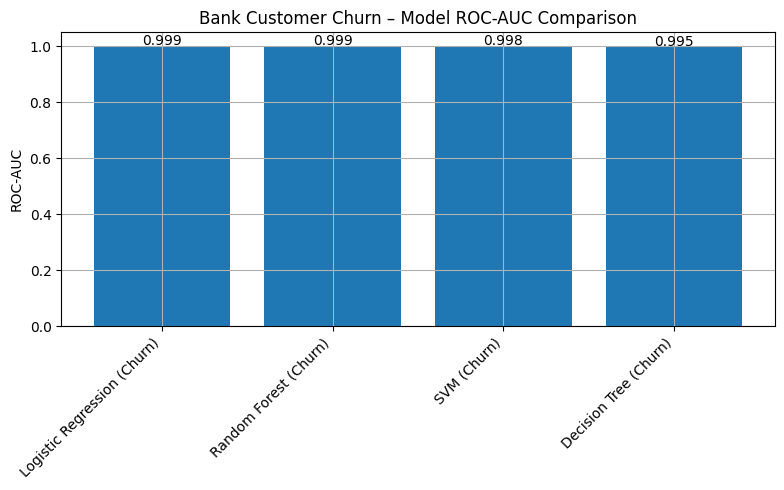

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(results_churn["Model"], results_churn["ROC_AUC"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("ROC-AUC")
plt.title("Bank Customer Churn – Model ROC-AUC Comparison")
for i, v in enumerate(results_churn["ROC_AUC"]):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()


In [ ]:
# === EXPORT ALL IMPORTANT RESULTS ===

# Create comparison_smote DataFrame
comparison_smote = pd.DataFrame({
    "Model": ["Logistic Regression", "Logistic Regression + SMOTE"],
    "ROC_AUC": [lr_auc, roc_auc_s]
})
comparison_smote = comparison_smote.sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)

print("=== 1) Bank Marketing – Main Models (results_bank) ===")
print()
print(results_bank.to_string(index=False))

print("\n\n=== 2) SMOTE Comparison – Bank Marketing (comparison_smote) ===")
print()
print(comparison_smote.to_string(index=False))

print("\n\n=== 3) Customer Churn – Main Models (results_churn) ===")
print()
print(results_churn.to_string(index=False))

=== 1) Bank Marketing – Main Models (results_bank) ===

              Model  ROC_AUC
Logistic Regression 0.770108
      Decision Tree 0.614057


=== 2) SMOTE Comparison – Bank Marketing (comparison_smote) ===

                      Model  ROC_AUC
        Logistic Regression 0.770108
Logistic Regression + SMOTE 0.764484


=== 3) Customer Churn – Main Models (results_churn) ===

                      Model  ROC_AUC
Logistic Regression (Churn) 0.999014
      Random Forest (Churn) 0.998826
                SVM (Churn) 0.997562
      Decision Tree (Churn) 0.995280
